<a href="https://colab.research.google.com/github/Vedant2100/w26/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1. Setup

 Normalization using train data mean and train data standard dev to both training and test data.

In [17]:
from datasets import load_dataset
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = load_dataset("ylecun/mnist")

def format_data(split, mean=None, std=None):
    images = np.array([np.array(img).flatten() for img in split["image"]])
    if mean is None or std is None:
        mean = np.mean(images, axis=0)
        std = np.std(images, axis=0)
    std_copy = std.copy()
    std_copy[std_copy == 0] = 1.0
    X = (images - mean) / std_copy
    y = np.array(split["label"])
    return X, y, mean, std

# Q2. MNIST models with diff k and p

##2.1
 I think there might be a typo in the question, because no dropout regularisation would correpsond to p = 0, not p = 1 as mention in the question. With p = 0.0, as k (the number of units )increases, the training accuracy and test accuracy both improve. At no k in the current set, the training accuracy has become 100%. I tried out a higher learning rate than the default value of 0.001, 0.01 and the training accuracy did get to 100% on k = 35.

In [18]:
X_train, y_train, train_mean, train_std = format_data(dataset["train"])
X_test, y_test, _, _ = format_data(dataset["test"], train_mean, train_std)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_train: (60000,)
Shape of y_test: (10000,)


In [19]:
np.random.seed(0)
idxs = []
for c in range(10):
    class_idxs = np.where(y_train == c)[0]
    chosen = np.random.choice(class_idxs, size=1000, replace=True)
    idxs.append(chosen)
idxs = np.concatenate(idxs)
np.random.shuffle(idxs)
X_train = X_train[idxs]
y_train = y_train[idxs]

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class shallowNN(nn.Module):
    def __init__(self, k = 1, p = 0.1):
        super(shallowNN, self).__init__()
        self.fc1 = nn.Linear(784, k)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        self.dropout = nn.Dropout(p)
        self.fc2 = nn.Linear(k, 10)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = shallowNN()

In [27]:
import matplotlib.pyplot as plt
import tqdm


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs = 80, lr = 0.001):
    model = shallowNN(k=k, p=p)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    train_acc = {}
    test_acc = {}
    loss_hist = {}
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss_hist[(k, p, epoch)] = loss.item()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            model.eval()
            train_acc[(k, p, epoch)] = (model(inputs).argmax(dim=1) == labels).float().mean().item()
            test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
            test_acc[(k, p, epoch)] = (test_outputs.argmax(dim=1) == torch.tensor(y_test, dtype=torch.long)).float().mean().item()
            model.train()
    return train_acc, test_acc, loss_hist


SyntaxError: parameter without a default follows parameter with a default (ipython-input-6374795.py, line 11)

## LR = 0.001 (default)

100%|██████████| 80/80 [00:02<00:00, 27.73it/s]


Trained model with k=1, p=1.0


100%|██████████| 80/80 [00:03<00:00, 20.37it/s]


Trained model with k=5, p=1.0


100%|██████████| 80/80 [00:03<00:00, 20.95it/s]


Trained model with k=15, p=1.0


100%|██████████| 80/80 [00:04<00:00, 16.81it/s]


Trained model with k=35, p=1.0


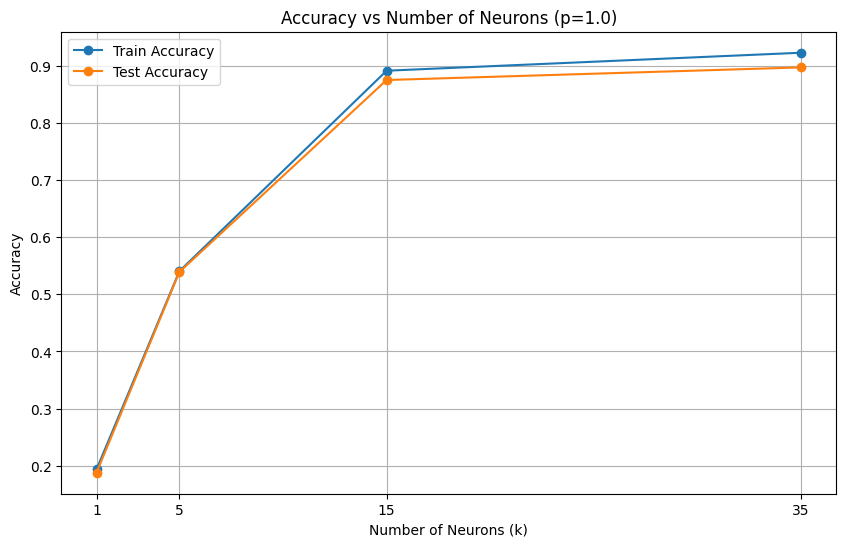

In [21]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [1.0]
epochs = 80
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr = 0.001)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('Number of Neurons (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Number of Neurons (p={p})')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"\nFinal train accuracy k = {k}, p = {p}: {train_acc[(k, p, epochs-1)]}")
    print(f"\nFinal test accuracy k = {k}, p = {p}: {test_acc[(k, p, epochs-1)]}")


## LR = 0.01

100%|██████████| 80/80 [00:03<00:00, 25.12it/s]


Trained model with k=1, p=1.0


100%|██████████| 80/80 [00:03<00:00, 20.99it/s]


Trained model with k=5, p=1.0


100%|██████████| 80/80 [00:04<00:00, 19.95it/s]


Trained model with k=15, p=1.0


100%|██████████| 80/80 [00:05<00:00, 14.48it/s]


Trained model with k=35, p=1.0


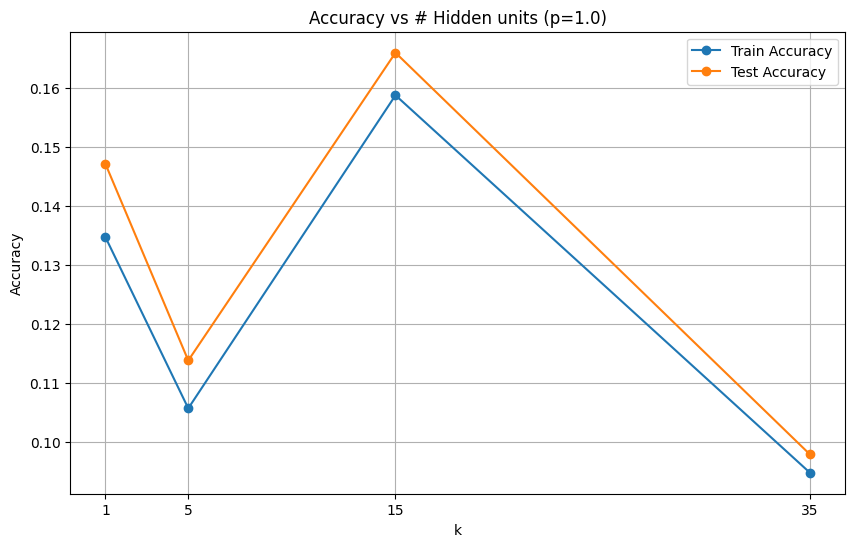

Final train accuracy k = 1, p = 1.0: 0.1347000002861023
Final test accuracy k = 1, p = 1.0: 0.14710000157356262
Final train accuracy k = 5, p = 1.0: 0.10570000112056732
Final test accuracy k = 5, p = 1.0: 0.11379999667406082
Final train accuracy k = 15, p = 1.0: 0.15870000422000885
Final test accuracy k = 15, p = 1.0: 0.16590000689029694
Final train accuracy k = 35, p = 1.0: 0.09480000287294388
Final test accuracy k = 35, p = 1.0: 0.09790000319480896


In [23]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [1.0]
epochs = 80
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr = 0.01)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('Number of Neurons (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Number of Neurons (p={p})')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"\nFinal train accuracy k = {k}, p = {p}: {train_acc[(k, p, epochs-1)]}")
    print(f"\nFinal test accuracy k = {k}, p = {p}: {test_acc[(k, p, epochs-1)]}")

## 2.2

1. Generally the training accuracy has decreased with increasing p which makes sense as the more neurons are randomly deactivated, the network's capacity to learning data lessens. It dropped a lot in p = 1.0 case where in all neurons were deactivated, then the model didnt learn anything.

2. When p is smaller its generally more difficult to optimize than when p is higher because less number of gradients have to be calculated and backpropagated in this case than higher p.

100%|██████████| 80/80 [00:01<00:00, 45.81it/s]


Trained model with k=1, p=0.1


100%|██████████| 80/80 [00:02<00:00, 33.11it/s]


Trained model with k=5, p=0.1


100%|██████████| 80/80 [00:02<00:00, 30.48it/s]


Trained model with k=15, p=0.1


100%|██████████| 80/80 [00:04<00:00, 17.74it/s]


Trained model with k=35, p=0.1


100%|██████████| 80/80 [00:01<00:00, 45.86it/s]


Trained model with k=1, p=0.25


100%|██████████| 80/80 [00:02<00:00, 32.46it/s]


Trained model with k=5, p=0.25


100%|██████████| 80/80 [00:02<00:00, 29.76it/s]


Trained model with k=15, p=0.25


100%|██████████| 80/80 [00:04<00:00, 18.60it/s]


Trained model with k=35, p=0.25


100%|██████████| 80/80 [00:01<00:00, 41.50it/s]


Trained model with k=1, p=0.5


100%|██████████| 80/80 [00:02<00:00, 32.86it/s]


Trained model with k=5, p=0.5


100%|██████████| 80/80 [00:02<00:00, 29.46it/s]


Trained model with k=15, p=0.5


100%|██████████| 80/80 [00:03<00:00, 20.27it/s]


Trained model with k=35, p=0.5


100%|██████████| 80/80 [00:02<00:00, 39.00it/s]


Trained model with k=1, p=1.0


100%|██████████| 80/80 [00:02<00:00, 32.53it/s]


Trained model with k=5, p=1.0


100%|██████████| 80/80 [00:02<00:00, 32.13it/s]


Trained model with k=15, p=1.0


100%|██████████| 80/80 [00:03<00:00, 23.58it/s]


Trained model with k=35, p=1.0


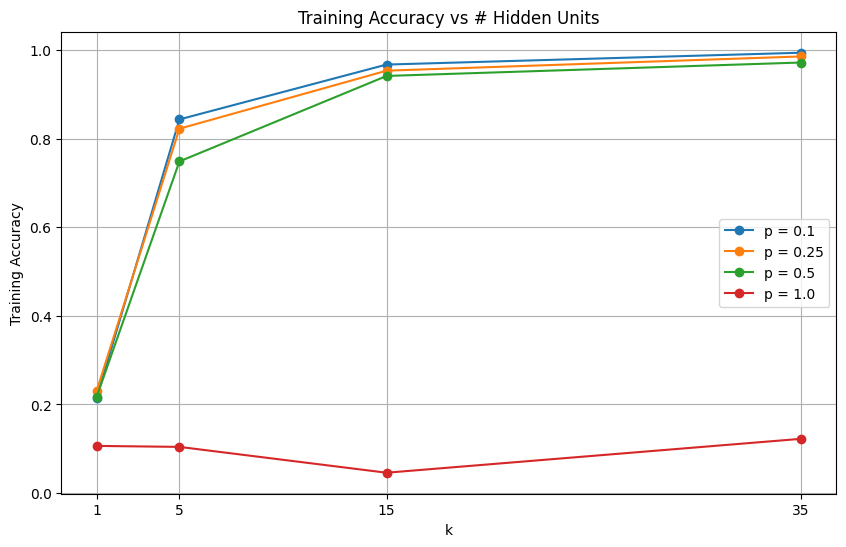

Final train accuracy k = 1, p = 0.1: 0.21359999477863312
Final train accuracy k = 5, p = 0.1: 0.8432000279426575
Final train accuracy k = 15, p = 0.1: 0.9670000076293945
Final train accuracy k = 35, p = 0.1: 0.9937000274658203
Final train accuracy k = 1, p = 0.25: 0.22949999570846558
Final train accuracy k = 5, p = 0.25: 0.8222000002861023
Final train accuracy k = 15, p = 0.25: 0.9531999826431274
Final train accuracy k = 35, p = 0.25: 0.9853000044822693
Final train accuracy k = 1, p = 0.5: 0.21619999408721924
Final train accuracy k = 5, p = 0.5: 0.7483999729156494
Final train accuracy k = 15, p = 0.5: 0.9412999749183655
Final train accuracy k = 35, p = 0.5: 0.9715999960899353
Final train accuracy k = 1, p = 1.0: 0.10649999976158142
Final train accuracy k = 5, p = 1.0: 0.10429999977350235
Final train accuracy k = 15, p = 1.0: 0.04600000008940697
Final train accuracy k = 35, p = 1.0: 0.12250000238418579


In [24]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
torch.manual_seed(0)
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr = 0.01)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('Number of Neurons (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Number of Neurons (p={p})')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"\nFinal train accuracy k = {k}, p = {p}: {train_acc[(k, p, epochs-1)]}")
    print(f"\nFinal test accuracy k = {k}, p = {p}: {test_acc[(k, p, epochs-1)]}")

plt.figure(figsize=(10, 6))

for p in pvals:
    plt.plot(kvals, [train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()

Currently, none of the networks have reached training accuracy exactly 100% though k = 35, p = 0.1 is very close. In order to determine at what min k among given values will it be achieved, I have to increase the number of epochs.

## 2.2

3. For all values of p (except P = 1.0), a training accuracy of 100% is achieved at k = 35, given sufficient epochs to train.
For p = 1.0, a 100% accuracy will never be achieved as the model won't ever be able to learn the training data.

100%|██████████| 300/300 [00:07<00:00, 42.51it/s]


Trained model with k=1, p=0.1


100%|██████████| 300/300 [00:09<00:00, 31.56it/s]


Trained model with k=5, p=0.1


100%|██████████| 300/300 [00:14<00:00, 20.48it/s]


Trained model with k=15, p=0.1


100%|██████████| 300/300 [00:18<00:00, 16.42it/s]


Trained model with k=35, p=0.1


100%|██████████| 300/300 [00:07<00:00, 40.67it/s]


Trained model with k=1, p=0.25


100%|██████████| 300/300 [00:11<00:00, 26.15it/s]


Trained model with k=5, p=0.25


100%|██████████| 300/300 [00:11<00:00, 26.70it/s]


Trained model with k=15, p=0.25


100%|██████████| 300/300 [00:17<00:00, 17.07it/s]


Trained model with k=35, p=0.25


100%|██████████| 300/300 [00:07<00:00, 41.23it/s]


Trained model with k=1, p=0.5


100%|██████████| 300/300 [00:10<00:00, 29.17it/s]


Trained model with k=5, p=0.5


100%|██████████| 300/300 [00:13<00:00, 22.16it/s]


Trained model with k=15, p=0.5


100%|██████████| 300/300 [00:19<00:00, 15.34it/s]


Trained model with k=35, p=0.5


100%|██████████| 300/300 [00:07<00:00, 40.90it/s]


Trained model with k=1, p=1.0


100%|██████████| 300/300 [00:09<00:00, 30.27it/s]


Trained model with k=5, p=1.0


100%|██████████| 300/300 [00:12<00:00, 23.97it/s]


Trained model with k=15, p=1.0


100%|██████████| 300/300 [00:15<00:00, 19.01it/s]


Trained model with k=35, p=1.0


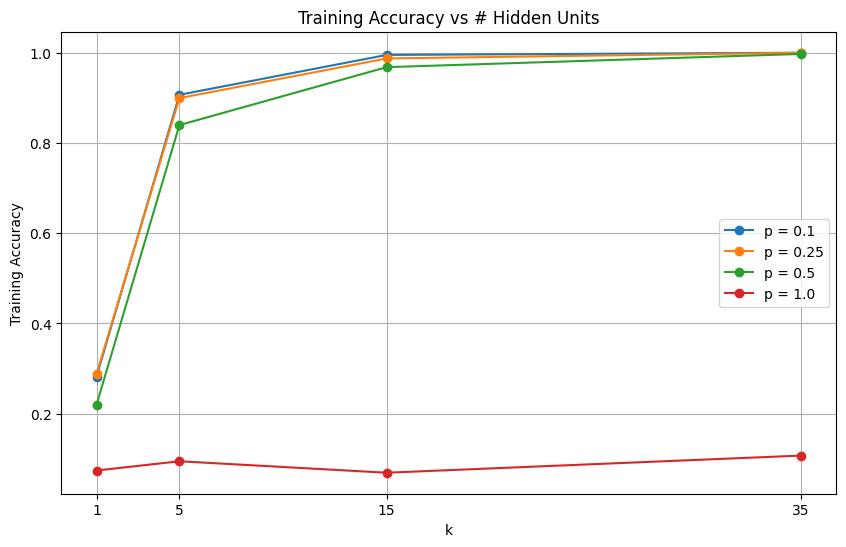

Final train accuracy k = 1, p = 0.1: 0.28189998865127563
Final train accuracy k = 5, p = 0.1: 0.9067000150680542
Final train accuracy k = 15, p = 0.1: 0.9951000213623047
Final train accuracy k = 35, p = 0.1: 1.0
Final train accuracy k = 1, p = 0.25: 0.28780001401901245
Final train accuracy k = 5, p = 0.25: 0.899399995803833
Final train accuracy k = 15, p = 0.25: 0.9872999787330627
Final train accuracy k = 35, p = 0.25: 0.9998999834060669
Final train accuracy k = 1, p = 0.5: 0.21960000693798065
Final train accuracy k = 5, p = 0.5: 0.8396000266075134
Final train accuracy k = 15, p = 0.5: 0.9679999947547913
Final train accuracy k = 35, p = 0.5: 0.9973000288009644
Final train accuracy k = 1, p = 1.0: 0.0738999992609024
Final train accuracy k = 5, p = 1.0: 0.09440000355243683
Final train accuracy k = 15, p = 1.0: 0.0689999982714653
Final train accuracy k = 35, p = 1.0: 0.10700000077486038


In [25]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 300
torch.manual_seed(0)
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr = 0.01)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('Number of Neurons (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Number of Neurons (p={p})')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"\nFinal train accuracy k = {k}, p = {p}: {train_acc[(k, p, epochs-1)]}")
    print(f"\nFinal test accuracy k = {k}, p = {p}: {test_acc[(k, p, epochs-1)]}")

plt.figure(figsize=(10, 6))

for p in pvals:
    plt.plot(kvals, [train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()


## 2.3

1. Yes, generally higher the dropout (1-p) or lower the p, the test accuracy is higher (except in the case of p = 0) , it makes sense because the model is more generalizable with more dropout.

2. For k = 35, and p = 0.0, i get highest test accuracy (i.e. no dropout case)

100%|██████████| 80/80 [00:03<00:00, 20.95it/s]


Trained model with k=1, p=0.1


100%|██████████| 80/80 [00:04<00:00, 18.39it/s]


Trained model with k=5, p=0.1


100%|██████████| 80/80 [00:03<00:00, 20.81it/s]


Trained model with k=15, p=0.1


100%|██████████| 80/80 [00:06<00:00, 12.86it/s]


Trained model with k=35, p=0.1


100%|██████████| 80/80 [00:02<00:00, 29.59it/s]


Trained model with k=1, p=0.25


100%|██████████| 80/80 [00:03<00:00, 20.86it/s]


Trained model with k=5, p=0.25


100%|██████████| 80/80 [00:04<00:00, 16.61it/s]


Trained model with k=15, p=0.25


100%|██████████| 80/80 [00:05<00:00, 14.15it/s]


Trained model with k=35, p=0.25


100%|██████████| 80/80 [00:02<00:00, 26.93it/s]


Trained model with k=1, p=0.5


100%|██████████| 80/80 [00:04<00:00, 18.69it/s]


Trained model with k=5, p=0.5


100%|██████████| 80/80 [00:03<00:00, 20.58it/s]


Trained model with k=15, p=0.5


100%|██████████| 80/80 [00:06<00:00, 11.87it/s]


Trained model with k=35, p=0.5


100%|██████████| 80/80 [00:03<00:00, 20.20it/s]


Trained model with k=1, p=1.0


100%|██████████| 80/80 [00:04<00:00, 18.31it/s]


Trained model with k=5, p=1.0


100%|██████████| 80/80 [00:04<00:00, 17.73it/s]


Trained model with k=15, p=1.0


100%|██████████| 80/80 [00:06<00:00, 12.63it/s]


Trained model with k=35, p=1.0


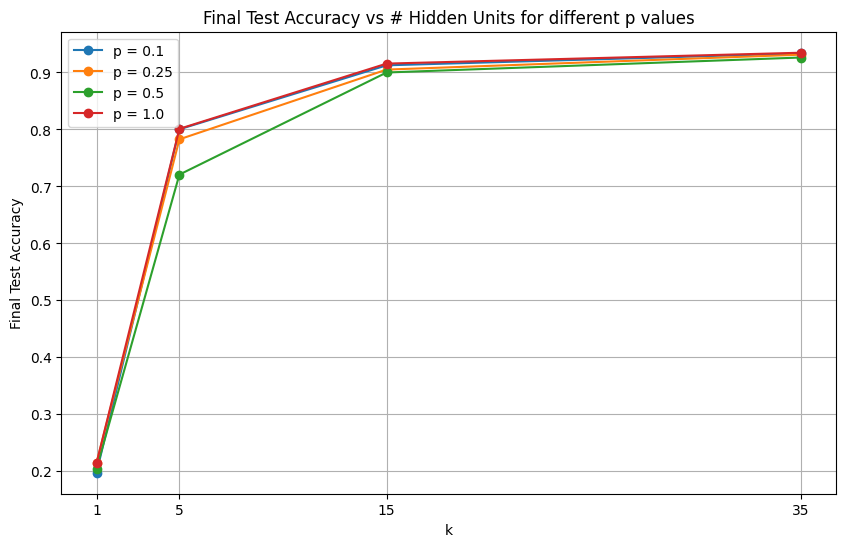

In [26]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
torch.manual_seed(0)
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr = 0.01)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('Number of Neurons (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Number of Neurons (p={p})')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"\nFinal train accuracy k = {k}, p = {p}: {train_acc[(k, p, epochs-1)]}")
    print(f"\nFinal test accuracy k = {k}, p = {p}: {test_acc[(k, p, epochs-1)]}")

plt.figure(figsize=(10, 6))

for p in pvals:
    plt.plot(kvals, [test_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.title('Trest Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()